# Speech Emotion Recognition CREMA-D Dataset

In [1]:
# Import necessary libraries
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.utils import class_weight

# Set plot style for EDA
sns.set(style="whitegrid")

# Define dataset path
data_path = '/kaggle/input/cremad/AudioWAV'

# Define the path to your audio clips
audio_path = '/kaggle/input/cremad/AudioWAV'

# Initialize lists to hold metadata information
file_names = []
emotions = []
speakers = []

# Dictionary to map the emotion code in the filename to the full emotion label
emotion_dict = {
    "ANG": "Anger",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happiness",
    "NEU": "Neutral",
    "SAD": "Sadness"
}

# Loop through all files in the folder
for file in os.listdir(audio_path):
    if file.endswith(".wav"):
        # Split the filename to extract metadata
        parts = file.split('_')
        speaker_id = parts[0]
        emotion_code = parts[2]
        
        # Append data to lists
        file_names.append(file)
        speakers.append(speaker_id)
        emotions.append(emotion_dict.get(emotion_code, "Unknown"))

# Create a DataFrame for the metadata
meta_data = pd.DataFrame({
    'file': file_names,
    'speaker': speakers,
    'emotion': emotions
})

# Save the metadata to a CSV file
meta_data.to_csv('crema_d_metadata.csv', index=False)

#read csv file
metadata = pd.read_csv('crema_d_metadata.csv')

# Display the first few rows of the metadata
metadata.head()

,file,speaker,emotion
0,1028_TSI_DIS_XX.wav,1028,Disgust
1,1075_IEO_HAP_LO.wav,1075,Happiness
2,1084_ITS_HAP_XX.wav,1084,Happiness
3,1067_IWW_DIS_XX.wav,1067,Disgust
4,1066_TIE_DIS_XX.wav,1066,Disgust


# 1.EDA:Analyzing Emotion Distribution

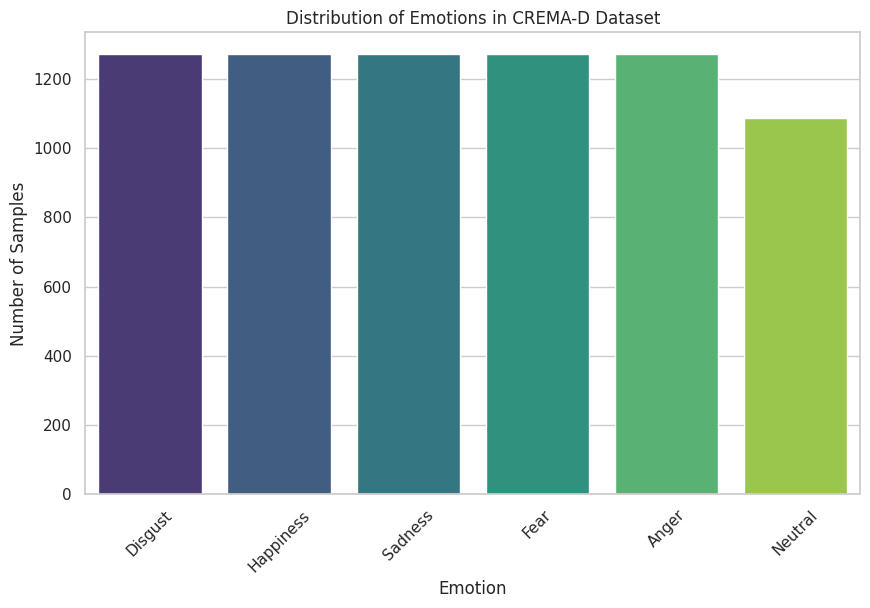

In [2]:
# Count the number of samples per emotion
emotion_counts = metadata['emotion'].value_counts()

# Plot the distribution of emotions
plt.figure(figsize=(10,6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
plt.title('Distribution of Emotions in CREMA-D Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

## 2. EDA: Visualizing Audio Data

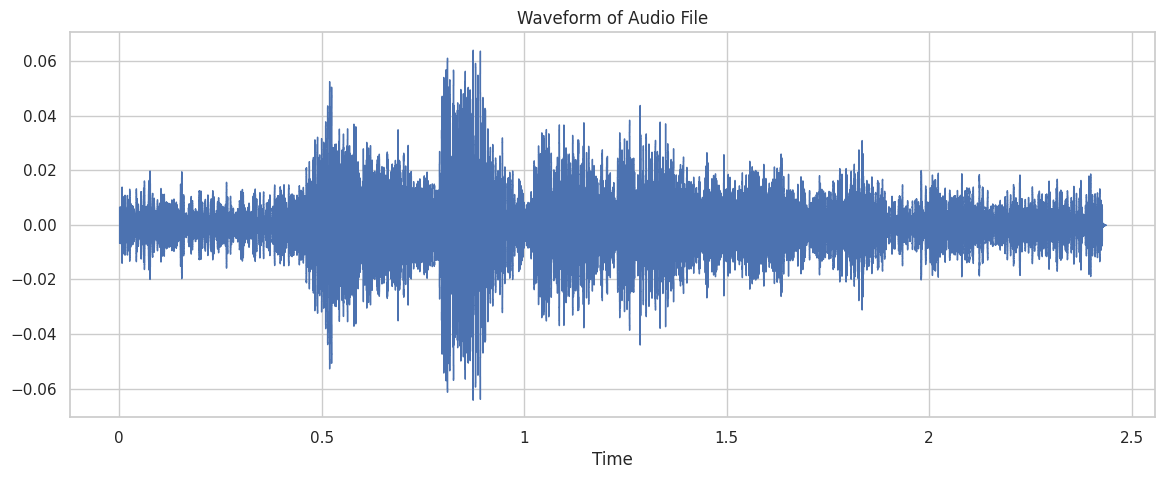

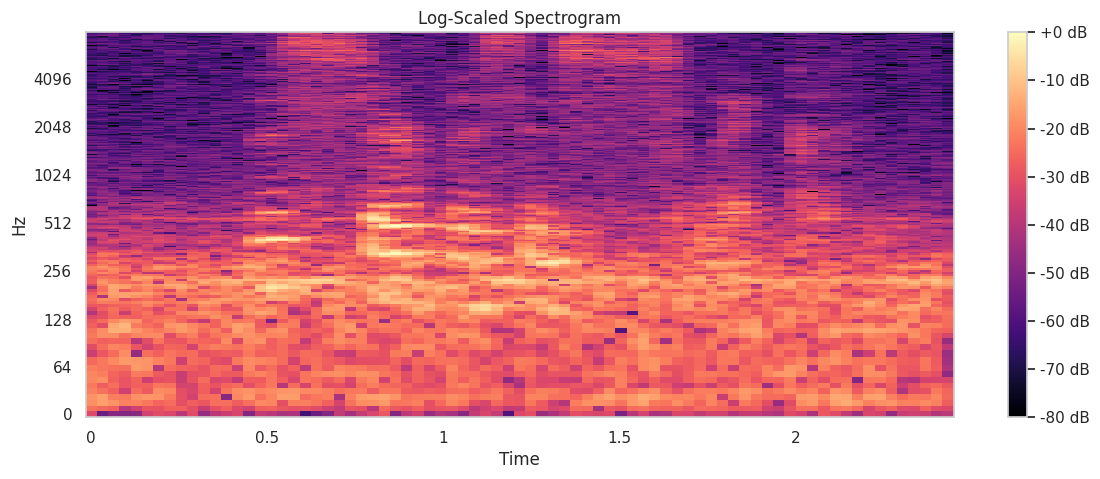

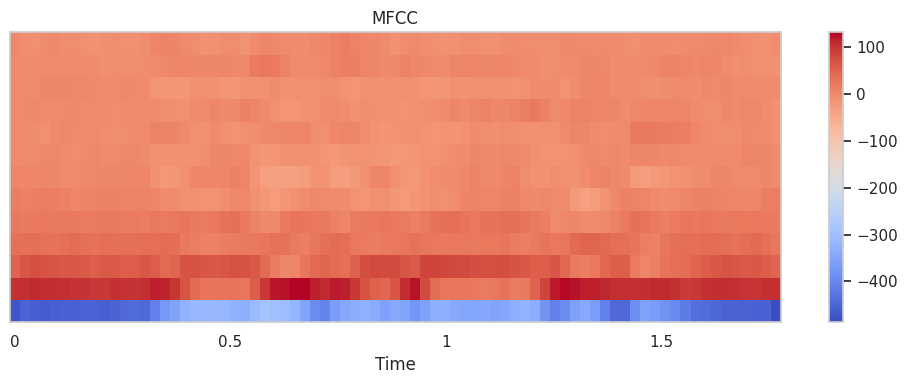

In [3]:
# Select a random audio file for visualization
sample_file = os.path.join(data_path, metadata['file'][0])
y, sr = librosa.load(sample_file, sr=None)

# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio File')
plt.show()

# Plot the spectrogram (log-scaled)
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Scaled Spectrogram')
plt.show()

# Plot MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

### 3. Preprocessing: Feature Extraction#
###  Extract MFCCs,Mel-Spectrogram

In [4]:
import multiprocessing as mp

# Data Augmentation Function
def augment_audio(y, sr):
    augmentations = []

    # Add noise
    noise_factor = 0.005
    y_noise = y + noise_factor * np.random.randn(len(y))
    augmentations.append(y_noise)

    # Time stretch (reduced to one stretch rate)
    rates = [1.2]  # Fewer time stretches to speed up
    for rate in rates:
        y_stretch = librosa.effects.time_stretch(y, rate=rate)
        augmentations.append(y_stretch)

    # Pitch shift with fewer n_steps
    n_steps_values = [1, -1]  # Reduced number of pitch shifts
    for n_steps in n_steps_values:
        y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        augmentations.append(y_shift)

    return augmentations

# Feature extraction: MFCC, Mel-spectrogram
def extract_combined_features(y, sr, n_mfcc=40, n_mels=128):
    # MFCC with delta and delta-delta features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfcc_features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

    # Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Stack all features together
    combined_features = np.hstack([
        np.mean(mfcc_features.T, axis=0),
        np.mean(mel_spectrogram_db.T, axis=0),       
    ])
    
    return combined_features

# Function to process a single file (with augmentations)
def process_file(row):
    file_path = os.path.join(audio_path, row['file'])
    emotion = row['emotion']

    # Load the audio file once
    y, sr = librosa.load(file_path, sr=None)

    features = []

    # Extract features for the original file
    combined_features = extract_combined_features(y, sr)
    
    # Append original features to the list
    features.append((combined_features, emotion))

    # Apply augmentations and extract features
    augmented_audios = augment_audio(y, sr)
    for aug_audio in augmented_audios:
        aug_combined_features = extract_combined_features(aug_audio, sr)

        # Append augmented features to the list
        features.append((aug_combined_features, emotion))

    return features

# Multiprocessing feature extraction
def extract_features_parallel(metadata, audio_path, num_workers=mp.cpu_count()):
    pool = mp.Pool(num_workers)
    results = pool.map(process_file, [row for _, row in metadata.iterrows()])
    pool.close()
    pool.join()

    # Unpack results
    features = []
    labels = []
    for result in results:
        for feature, label in result:
            features.append(feature)
            labels.append(label)
    
    return np.array(features), np.array(labels)

# Example Usage
X, y = extract_features_parallel(metadata, audio_path)

# Create DataFrame for the features
features_df = pd.DataFrame(X)
features_df['emotion'] = y

# Display unique emotions
features_df['emotion'].unique()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


array(['Disgust', 'Happiness', 'Sadness', 'Neutral', 'Fear', 'Anger'],
      dtype=object)

### 4. Preprocessing: Label Encoding
#### Encode the categorical emotion labels into numerical format for training models.

In [6]:
# Convert labels to numerical encoding (label encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features_df['emotion'] = le.fit_transform(features_df['emotion'])
# Check the order of the classes
print(le.classes_)
features_df['emotion'].unique()

[0 1 2 3 4 5]


array([1, 3, 5, 4, 2, 0])

### 5. Splitting the Dataset
#### Train-Test split for preparing the dataset for training.

In [7]:
# Split into training and testing sets
X = features_df.drop(columns=['emotion'])
y = features_df['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 6. Convert to numpy arrays for training

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### 7. Compute class weights to handle imbalanced data

In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

## 8. Models

## BiLSTM Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 248, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 248, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 248, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,854 (854.90 KB)

 Trainable params: 218,214 (852.40 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.2321 - loss: 3.4801 - val_accuracy: 0.3306 - val_loss: 1.8367 - learning_rate: 0.0010
Epoch 2/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3350 - loss: 1.7490 - val_accuracy: 0.2322 - val_loss: 1.9608 - learning_rate: 0.0010
Epoch 3/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3553 - loss: 1.6041 - val_accuracy: 0.3400 - val_loss: 1.5767 - learning_rate: 0.0010
Epoch 4/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3549 - loss: 1.5671 - val_accuracy: 0.2726 - val_loss: 1.6700 - learning_rate: 0.0010
Epoch 5/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3545 - loss: 1.5665 - val_accuracy: 0.3236 - val_loss: 1.6089 - learning_rate: 0.0010
Epoch 6/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3612 - loss: 1.5563 - val_accuracy: 0.3128 - val_loss: 1.6140 - learning_rate: 0.0010
Epoch 7/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3616 - l

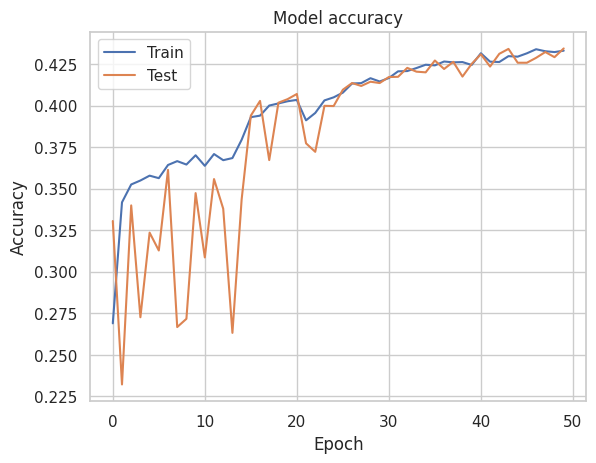

In [17]:
# Model 1: BiLSTM with Regularization and Batch Normalization
def build_bilstm_model(input_shape):
    model = tf.keras.models.Sequential()
    
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)), input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build BiLSTM Model
bilstm_model = build_bilstm_model((X_train.shape[1], 1))

# Reshape input data for LSTM
X_train_bilstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_bilstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Learning Rate Scheduler and Early Stopping Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train BiLSTM Model
bilstm_history = bilstm_model.fit(X_train_bilstm, y_train, 
                                  epochs=50, 
                                  batch_size=32, 
                                  validation_data=(X_test_bilstm, y_test), 
                                  class_weight=class_weights_dict,
                                  callbacks=[lr_scheduler])

# Plot training & validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Plot BiLSTM Accuracy
plot_accuracy(bilstm_history)

## CRNN Model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 246, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 246, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 123, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 123, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,878 (1.08 MB)

 Trainable params: 283,110 (1.08 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.2079 - loss: 2.1282 - val_accuracy: 0.2167 - val_loss: 1.8214 - learning_rate: 0.0010
Epoch 2/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.2337 - loss: 1.7473 - val_accuracy: 0.2386 - val_loss: 1.7384 - learning_rate: 0.0010
Epoch 3/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.2481 - loss: 1.7189 - val_accuracy: 0.2436 - val_loss: 1.8621 - learning_rate: 0.0010
Epoch 4/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.3568 - loss: 1.5473 - val_accuracy: 0.3658 - val_loss: 1.5090 - learning_rate: 0.0010
Epoch 5/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.3698 - loss: 1.5053 - val_accuracy: 0.2810 - val_loss: 1.8316 - learning_rate: 0.0010
Epoch 6/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.3855 - loss: 1.4835 - val_accuracy: 0.3252 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 7/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.3923 - l

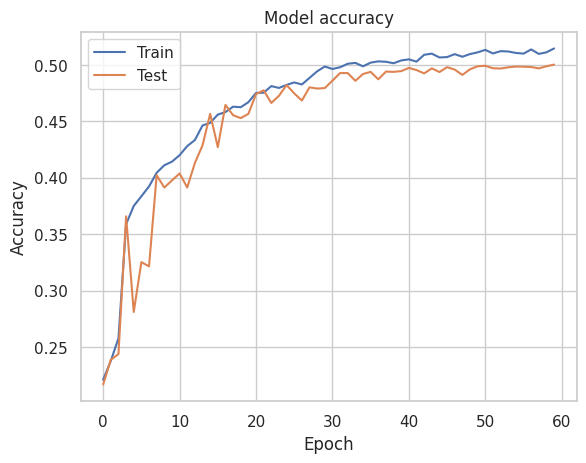

In [11]:
# CRNN Model with Convolution, LSTM, Dropout, and Batch Normalization
def build_crnn_model(input_shape):
    model = models.Sequential()

    # Convolutional Layer
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # LSTM Layers
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Dense Layers with Regularization
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build CRNN Model
crnn_model = build_crnn_model((X_train.shape[1], 1))

# Reshape the data for the Conv1D input
X_train_crnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_crnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the CRNN Model
crnn_history = crnn_model.fit(X_train_crnn, y_train, 
                              epochs=60, 
                              batch_size=32, 
                              validation_data=(X_test_crnn, y_test), 
                              class_weight=class_weights_dict,
                              callbacks=[lr_scheduler])

# Plot CRNN Accuracy
plot_accuracy(crnn_history)



## Transformer Model

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 248, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 248, 1)         │           248 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 248, 1)         │           446 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212 (4.73 KB)

 Trainable params: 1,212 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1730027083.401898    1208 service.cc:145] XLA service 0x7b0b9804d5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730027083.401974    1208 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 41/931 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1671 - loss: 1.8125 

I0000 00:00:1730027090.219023    1208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


931/931 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.1558 - loss: 1.7968 - val_accuracy: 0.1708 - val_loss: 1.7917 - learning_rate: 0.0010
Epoch 2/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1723 - loss: 1.7915 - val_accuracy: 0.1461 - val_loss: 1.7921 - learning_rate: 0.0010
Epoch 3/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1514 - loss: 1.7925 - val_accuracy: 0.1708 - val_loss: 1.7916 - learning_rate: 0.0010
Epoch 4/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1715 - loss: 1.7916 - val_accuracy: 0.1708 - val_loss: 1.7918 - learning_rate: 0.0010
Epoch 5/50
931/931 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1567 - loss: 1.7928 - val_accuracy: 0.1708 - val_loss: 1.7916 - learning_rate: 5.0000e-04


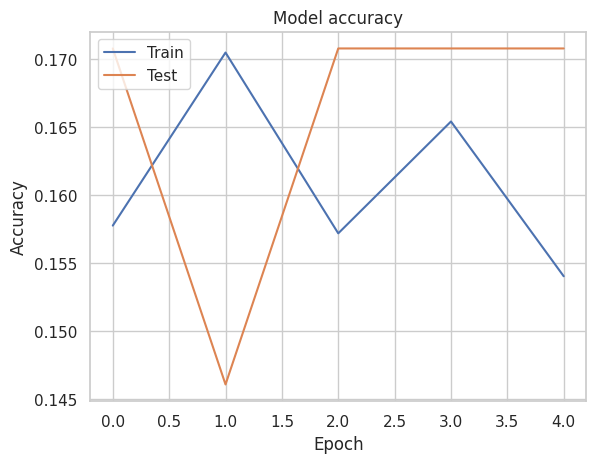

In [12]:
# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Positional Embedding for input sequence
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_embedding = layers.Embedding(input_dim=sequence_length, output_dim=d_model)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-2], delta=1)
        return inputs + self.positional_embedding(positions)

# Transformer Model
def build_transformer_model(input_shape, num_heads=8, ff_dim=128, num_layers=1):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding + Transformer Block
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(input_shape[1], num_heads, ff_dim)(x)

    # Global average pooling layer
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense layers with dropout and regularization
    x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(np.unique(y_train)), activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

# Build Transformer Model
transformer_model = build_transformer_model((X_train.shape[1], 1))

# Train the Transformer Model
transformer_history = transformer_model.fit(X_train_bilstm, y_train, 
                                            epochs=50, 
                                            batch_size=32, 
                                            validation_data=(X_test_bilstm, y_test), 
                                            class_weight=class_weights_dict,
                                            callbacks=[lr_scheduler, early_stopping])

# Plot Transformer Accuracy
plot_accuracy(transformer_history)


## ResNet Model

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 248, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 248, 64)   │        512 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 248, 64)   │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 64)   │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 248, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 248, 64)   │     12,352 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 248, 64)   │      4,160 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 64)   │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 248, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 248, 64)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 124, 64)   │          0 │ activation_5[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 124, 128)  │     24,704 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 128)  │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 124, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 124, 128)  │     49,280 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 124, 128)  │      8,320 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 128)  │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 622,342 (2.37 MB)

 Trainable params: 621,190 (2.37 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.2503 - loss: 1.7650 - val_accuracy: 0.3597 - val_loss: 1.5410 - learning_rate: 0.0010
Epoch 2/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2945 - loss: 1.6069 - val_accuracy: 0.3580 - val_loss: 1.5007 - learning_rate: 0.0010
Epoch 3/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3011 - loss: 1.5865 - val_accuracy: 0.3611 - val_loss: 1.5168 - learning_rate: 0.0010
Epoch 4/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3132 - loss: 1.5807 - val_accuracy: 0.3490 - val_loss: 1.5526 - learning_rate: 0.0010
Epoch 5/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3475 - loss: 1.5393 - val_accuracy: 0.3934 - val_loss: 1.4891 - learning_rate: 0.0010
Epoch 6/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3486 - loss: 1.5328 - val_accuracy: 0.3659 - val_loss: 1.5168 - learning_rate: 0.0010
Epoch 7/60
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3491 - loss: 1.5222 

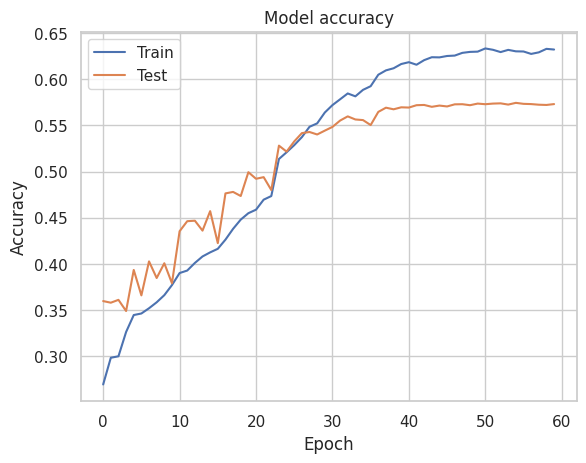

In [20]:
from tensorflow.keras.layers import Add, Activation,Conv1D,BatchNormalization,MaxPooling1D,Flatten,Dense,Dropout
def resnet_block(input, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size=kernel_size, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, padding="same")(input)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def build_resnet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution block
    x = Conv1D(64, kernel_size=7, padding="same", activation="relu")(inputs)
    
    # Residual blocks
    x = resnet_block(x, filters=64)
    x = MaxPooling1D(pool_size=2)(x)
    
    x = resnet_block(x, filters=128)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

# Build Resnet Model
resnet_model = build_resnet_model((X_train.shape[1], 1),6)

# Train the Resnet Model
resnet_history = resnet_model.fit(X_train_bilstm, y_train, 
                                            epochs=60, 
                                            batch_size=32, 
                                            validation_data=(X_test_bilstm, y_test), 
                                            class_weight=class_weights_dict,
                                            callbacks=[lr_scheduler])

# Plot Resnet Accuracy
plot_accuracy(resnet_history)


## Comparing Models

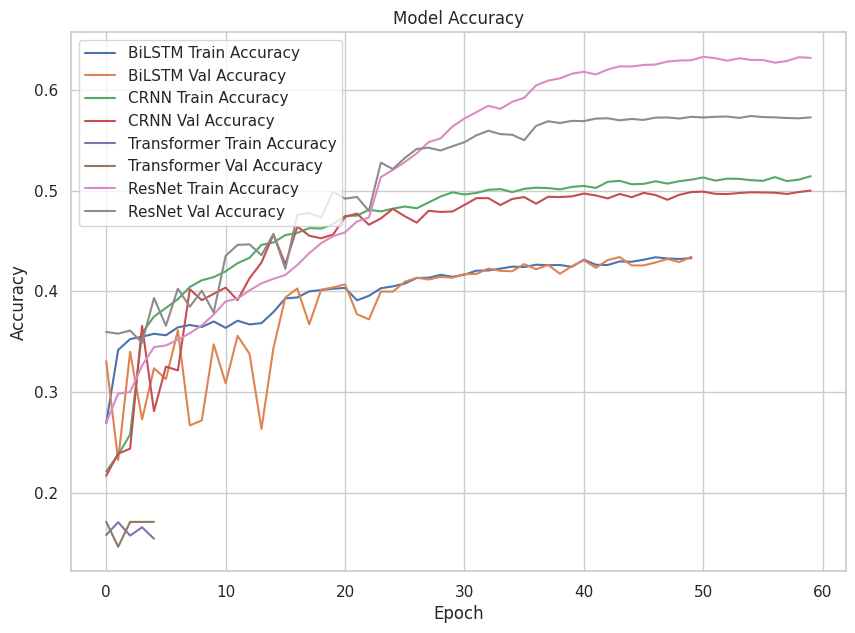

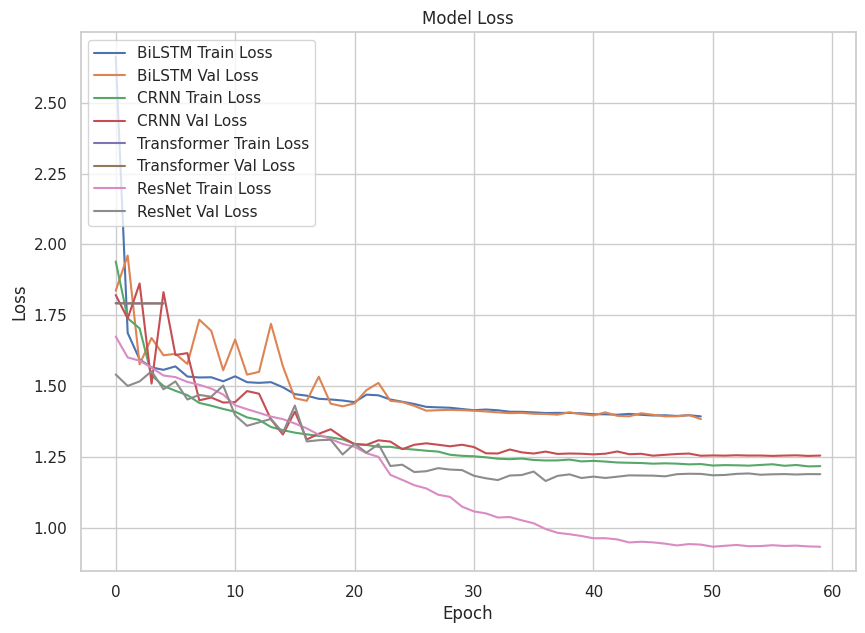

233/233 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


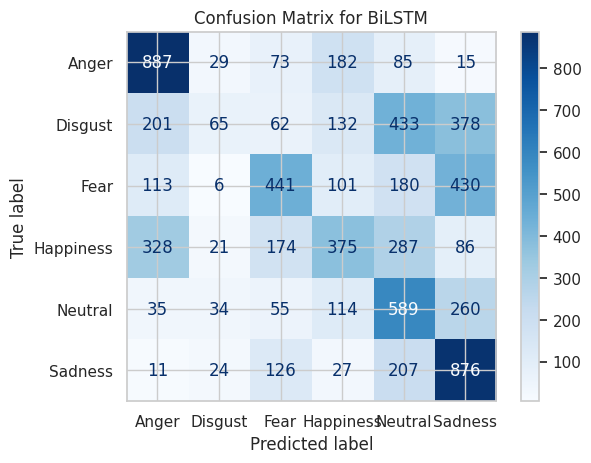

Classification Report for BiLSTM
              precision    recall  f1-score   support

       Anger       0.56      0.70      0.62      1271
     Disgust       0.36      0.05      0.09      1271
        Fear       0.47      0.35      0.40      1271
   Happiness       0.40      0.30      0.34      1271
     Neutral       0.33      0.54      0.41      1087
     Sadness       0.43      0.69      0.53      1271

    accuracy                           0.43      7442
   macro avg       0.43      0.44      0.40      7442
weighted avg       0.43      0.43      0.40      7442

233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


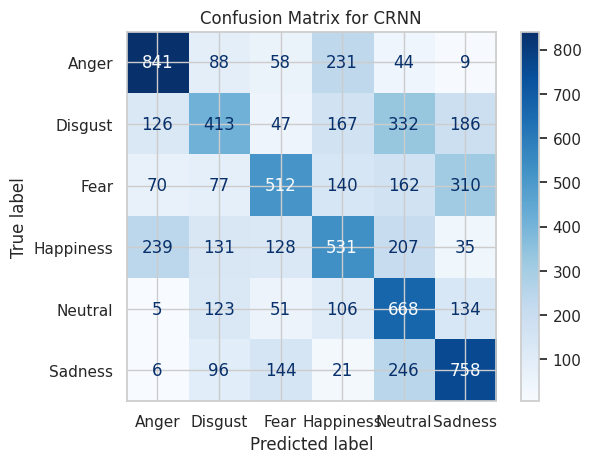

Classification Report for CRNN
              precision    recall  f1-score   support

       Anger       0.65      0.66      0.66      1271
     Disgust       0.45      0.32      0.38      1271
        Fear       0.54      0.40      0.46      1271
   Happiness       0.44      0.42      0.43      1271
     Neutral       0.40      0.61      0.49      1087
     Sadness       0.53      0.60      0.56      1271

    accuracy                           0.50      7442
   macro avg       0.50      0.50      0.50      7442
weighted avg       0.51      0.50      0.50      7442

233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


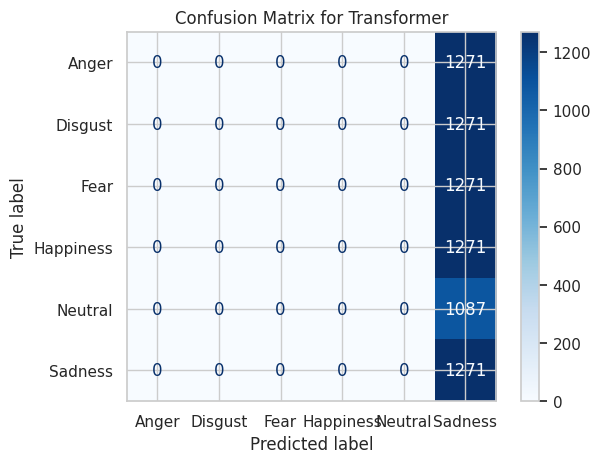

Classification Report for Transformer
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00      1271
     Disgust       0.00      0.00      0.00      1271
        Fear       0.00      0.00      0.00      1271
   Happiness       0.00      0.00      0.00      1271
     Neutral       0.00      0.00      0.00      1087
     Sadness       0.17      1.00      0.29      1271

    accuracy                           0.17      7442
   macro avg       0.03      0.17      0.05      7442
weighted avg       0.03      0.17      0.05      7442



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


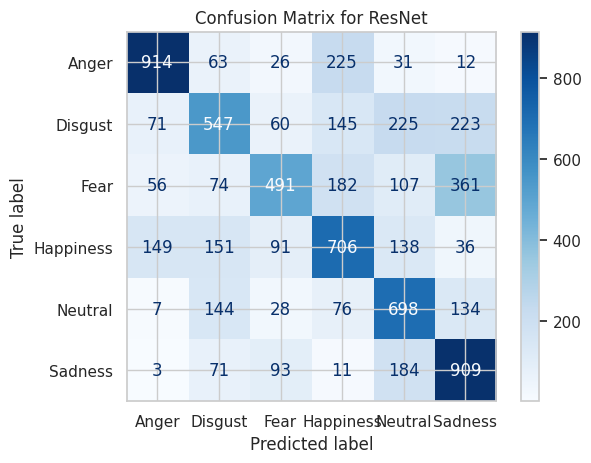

Classification Report for ResNet
              precision    recall  f1-score   support

       Anger       0.76      0.72      0.74      1271
     Disgust       0.52      0.43      0.47      1271
        Fear       0.62      0.39      0.48      1271
   Happiness       0.52      0.56      0.54      1271
     Neutral       0.50      0.64      0.57      1087
     Sadness       0.54      0.72      0.62      1271

    accuracy                           0.57      7442
   macro avg       0.58      0.57      0.57      7442
weighted avg       0.58      0.57      0.57      7442



In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Plot training & validation accuracy values for each model
def plot_accuracy(histories, labels):
    plt.figure(figsize=(10, 7))
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'{labels[i]} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{labels[i]} Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Plot training & validation loss values for each model
def plot_loss(histories, labels):
    plt.figure(figsize=(10, 7))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{labels[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{labels[i]} Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Function to plot confusion matrix for each model
def plot_confusion_matrix(y_true, y_preds, labels, model_name):
    cm = confusion_matrix(y_true, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Function to print classification report for each model
def print_classification_report(y_true, y_preds, labels, model_name):
    print(f'Classification Report for {model_name}')
    print(classification_report(y_true, y_preds, target_names=labels))

# Compare model performance
def compare_models(models, X_test, y_test, labels):
    for model_name, model in models.items():
        # Get predictions for the test set
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, labels, model_name)
        
        # Print classification report
        print_classification_report(y_test, y_pred, labels, model_name)

histories = [bilstm_history, crnn_history, transformer_history, resnet_history]
models = {"BiLSTM": bilstm_model, "CRNN": crnn_model, "Transformer": transformer_model, "ResNet": resnet_model}
labels = ['Anger','Disgust','Fear','Happiness','Neutral','Sadness'] #  emotion labels

# Plot accuracy and loss comparisons
plot_accuracy(histories, ["BiLSTM", "CRNN", "Transformer", "ResNet"])
plot_loss(histories, ["BiLSTM", "CRNN", "Transformer", "ResNet"])

# Compare confusion matrices and classification reports
compare_models(models, X_test, y_test, labels)


## Saving Models

In [23]:
bilstm_model.save('bilstm_model.h5')
crnn_model.save('crnn_model.h5')
transformer_model.save('transformer_model.h5')
resnet_model.save('resnet_model.h5')

# Deployment
# 1. Preprocessing Unseen Data

In [56]:
import numpy as np
import librosa

# Preprocess audio for both MFCC and Mel-spectrogram features
def preprocess_audio(file_path, sr=16000, n_mfcc=40, n_mels=128):
    # Load audio file
    y, sr = librosa.load(file_path, sr=sr)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfcc_features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    mfcc_scaled = np.mean(mfcc_features.T, axis=0)

    # Extract Mel-spectrogram features
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_scaled = np.mean(librosa.power_to_db(mel_spect).T, axis=0)
    
    # Combine MFCC and Mel features
    combined_features = np.concatenate([mfcc_scaled, mel_scaled])
    
    # Reshape for model input (1, feature_length, 1)
    combined_features = np.expand_dims(combined_features, axis=0)
    combined_features = np.expand_dims(combined_features, axis=-1)
    
    return combined_features

# 2. Model Inference on Unseen Data

In [57]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained models
bilstm_model = load_model('bilstm_model.h5')
crnn_model = load_model('crnn_model.h5')
#transformer_model = load_model('transformer_model.h5')
resnet_model = load_model('resnet_model.h5')

# Make predictions using each model
def predict_emotion(file_path, model, emotion_labels):
    # Preprocess the audio file
    preprocessed_audio = preprocess_audio(file_path)
    
    # Predict with the model
    prediction = model.predict(preprocessed_audio)
    
    # Get the predicted label
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    return predicted_emotion

# Example usage with unseen data
file_path = '/kaggle/input/test-audios/OAF_back_sad.wav'
emotion_labels = ['Anger','Disgust','Fear','Happiness','Neutral','Sadness']

# Predict with each model
bilstm_prediction = predict_emotion(file_path, bilstm_model, emotion_labels)
crnn_prediction = predict_emotion(file_path, crnn_model, emotion_labels)
#transformer_prediction = predict_emotion(file_path, transformer_model, emotion_labels)
resnet_prediction = predict_emotion(file_path, resnet_model, emotion_labels)

print("BiLSTM Prediction:", bilstm_prediction)
print("CRNN Prediction:", crnn_prediction)
#print("Transformer Prediction:", transformer_prediction)
print("ResNet Prediction:", resnet_prediction)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
BiLSTM Prediction: Fear
CRNN Prediction: Fear
ResNet Prediction: Fear
